In [2]:
from datetime import datetime


from energy_box_control.power_hub.control import control_power_hub, initial_control_state
from energy_box_control.power_hub.network import PowerHub, PowerHubSchedules
from energy_box_control.schedules import ConstSchedule
from datetime import timedelta
from energy_box_control.power_hub.control import initial_control_all_off

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

%load_ext autoreload 
%autoreload 2

sns.set_style("whitegrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def simulate_powerhub(schedules: PowerHubSchedules, control_function, steps: int, start_time: datetime = datetime.now(), step_size: timedelta = timedelta(seconds = 1)) -> tuple[pd.DataFrame, pd.DataFrame]:
    power_hub = PowerHub.power_hub(schedules)
    state = power_hub.simple_initial_state(start_time, step_size)
    control_state = initial_control_state()
    control_values = initial_control_all_off(power_hub)

    control_results = {}
    results = {}
    for _ in range(steps):
        state = power_hub.simulate(state, control_values)
        
        sensors = power_hub.sensors_from_state(state)
        
        control_state, control_values = control_function(power_hub, 
            control_state, sensors, state.time 
        )

        control_results[state.time.timestamp] = pd.DataFrame(
            {**{
                key: item.__dict__ 
                for key, item in control_values.name_to_control_values_mapping( 
                    power_hub
                ).items() 
            },**{'control_mode':{key: item.control_mode._value_ for key, item in control_state.__dict__.items() if key != 'setpoints'}}} 
            
        ).T.stack()

        results[state.time.timestamp] = pd.DataFrame(sensors.to_dict()).T.stack()

    control_data = pd.DataFrame(control_results).T
    data = pd.DataFrame(results).T

    return (data, control_data)

In [4]:
schedules = PowerHubSchedules(
    global_irradiance_schedule=ConstSchedule(800),
    cooling_demand_schedule=ConstSchedule(100000 / 24),
)

steps = 1000
step_size = timedelta(seconds = 60)

In [5]:
data, control_data = simulate_powerhub(schedules, control_power_hub, steps, datetime.now(), step_size)

In [6]:
appliances = ["heat_pipes", "hot_reservoir", "pcm", "yazaki", "cold_reservoir", "chiller", "preheat_reservoir", "outboard_exchange"]
temperatures = [(appliance,var) for appliance, var in data.columns if 'temperature' in var and appliance in appliances]
powers = [(appliance,var) for appliance, var in data.columns if 'power' in var and appliance in appliances]
flows = [(appliance,var) for appliance, var in data.columns if 'flow' in var and appliance in appliances]

waste_control_switch = (control_data['control_mode'].waste_control != control_data['control_mode'].waste_control.shift(1))
waste_control_switch = waste_control_switch[waste_control_switch].index

control_modes = control_data['control_mode']

def switch_stamps(control_modes, control_type):
    control_switch = (control_modes[control_type] != control_modes[control_type].shift(1))
    return control_switch[control_switch].index

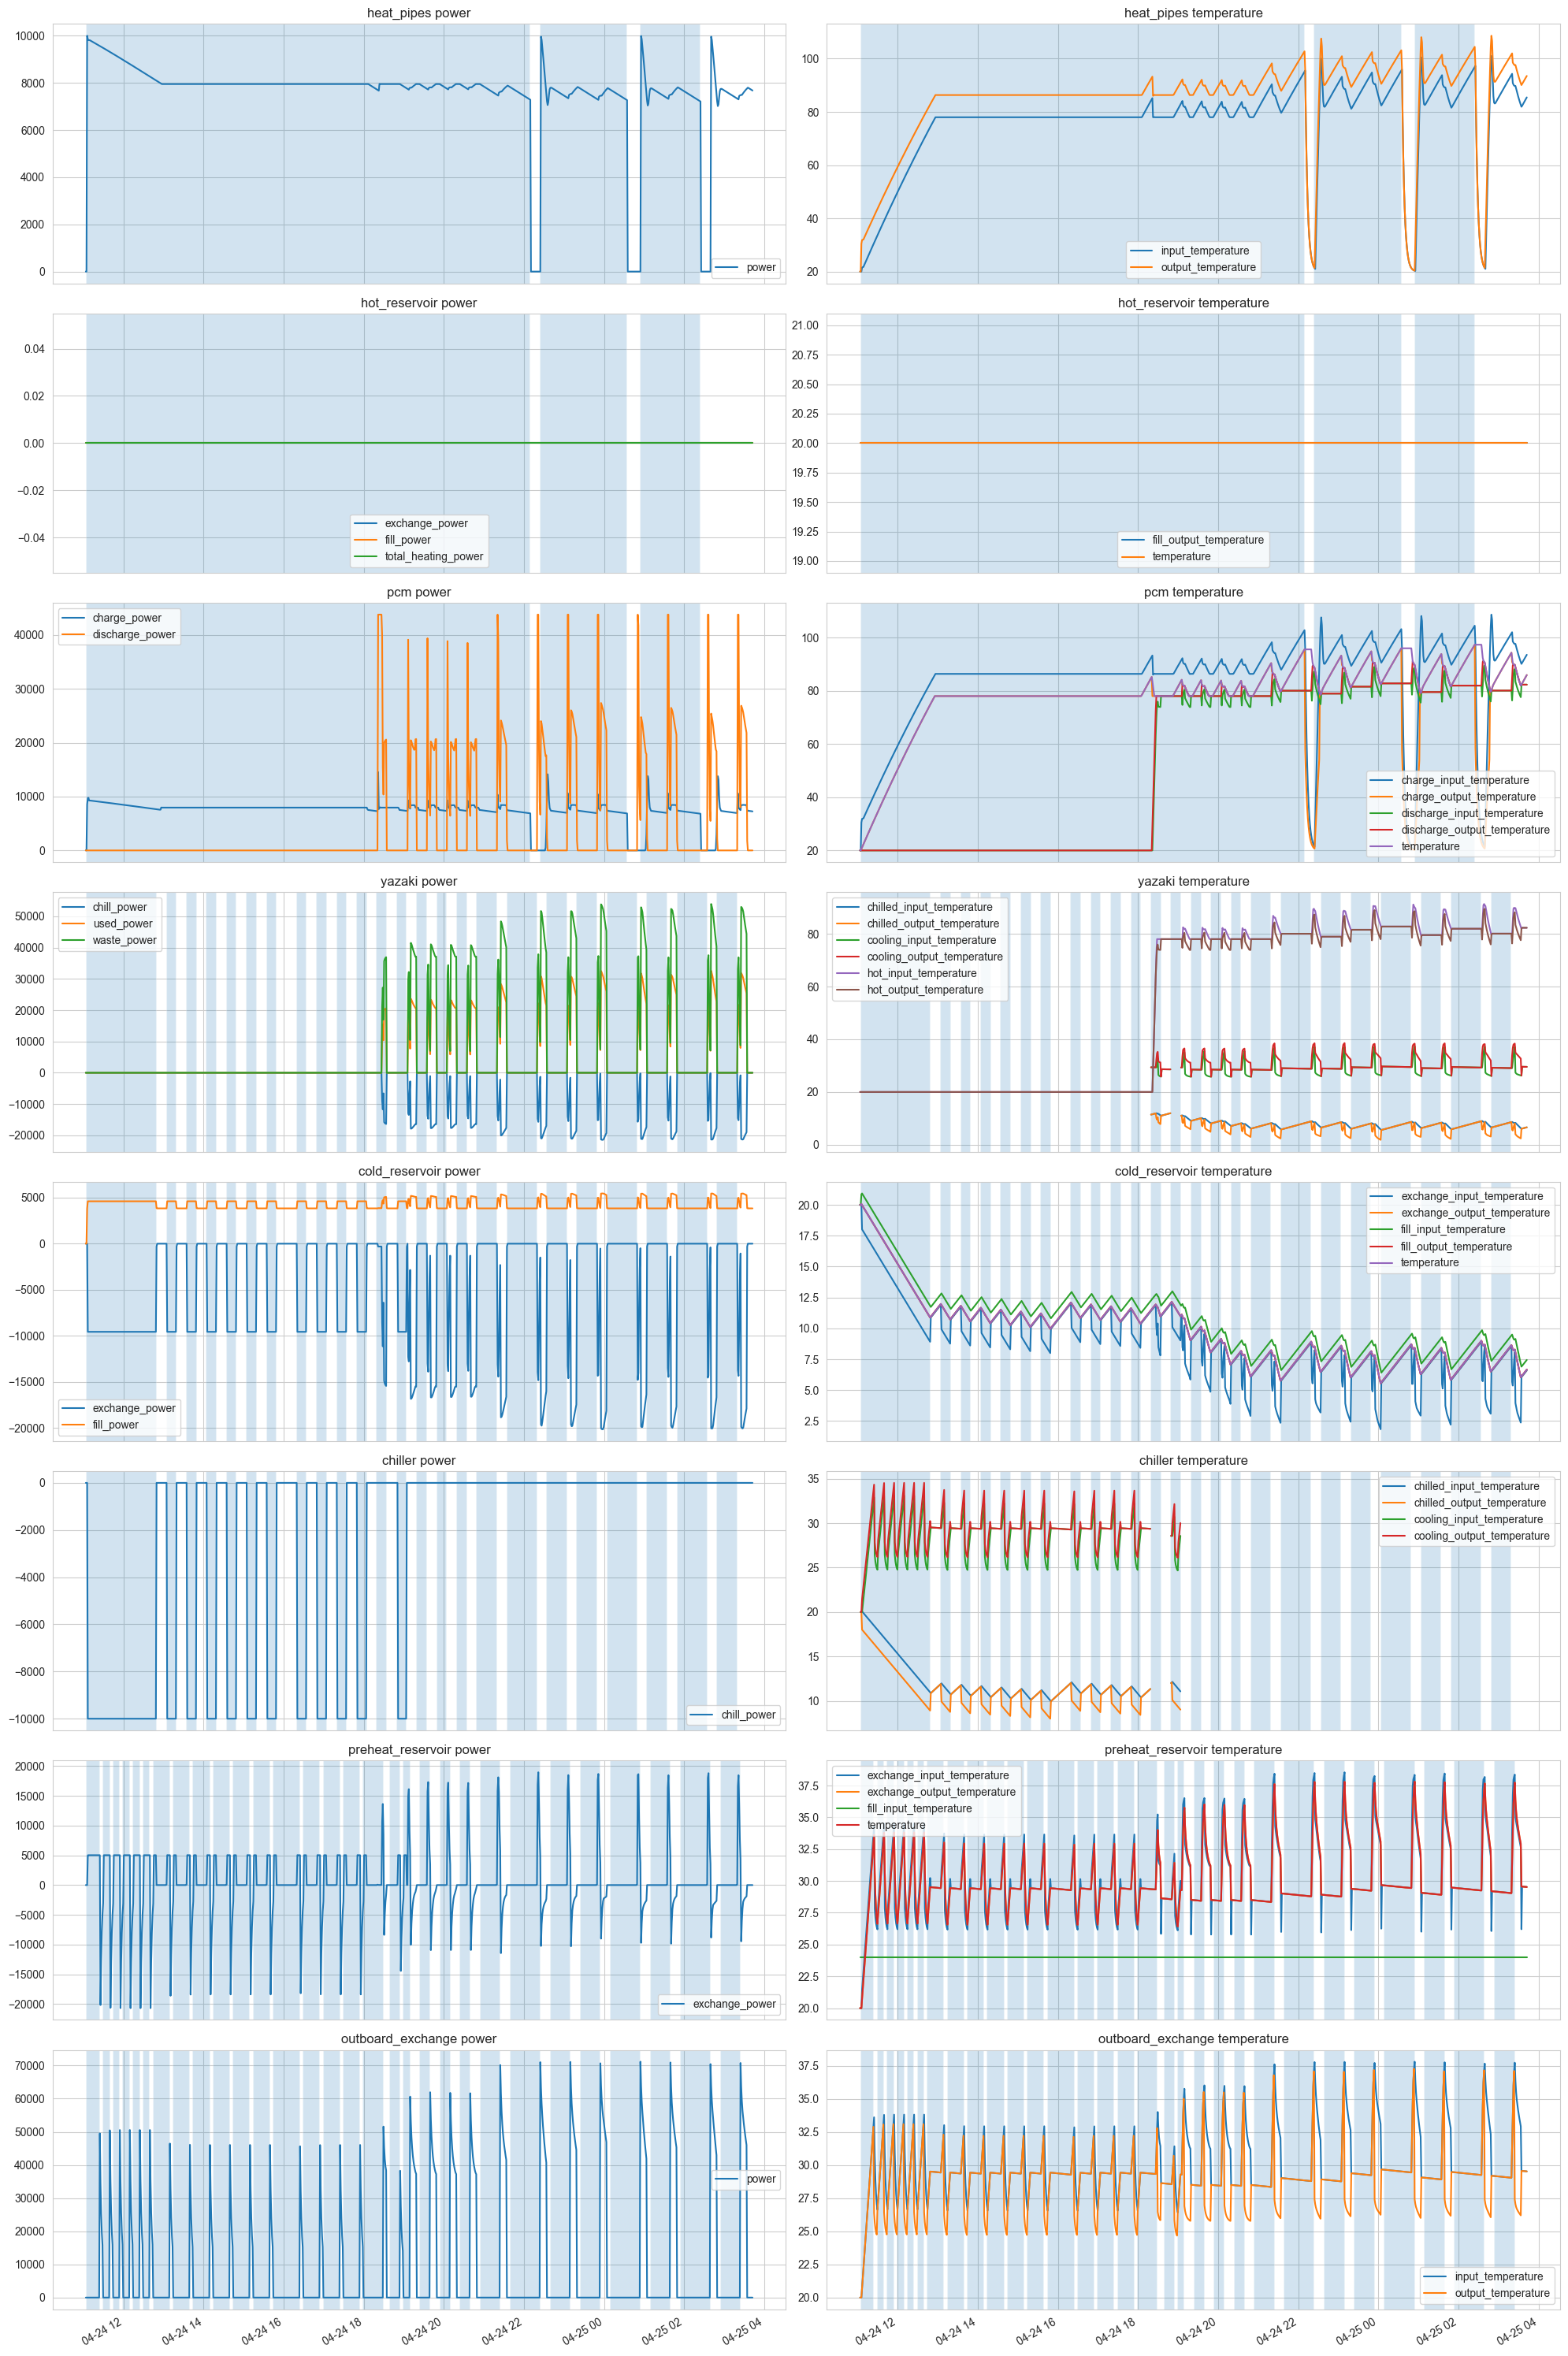

In [7]:
fig, axs = plt.subplots(len(appliances), 2, sharex = True, figsize = (20,30))

for i, appliance in enumerate(appliances):
    axs[i,0] = data[powers][appliance].plot(ax = axs[i,0], legend = False, title = appliance + ' power')
    axs[i,1] = data[temperatures][appliance].plot(ax = axs[i,1], legend = False, title = appliance + ' temperature')

    axs[i,0].legend(loc = "best")
    axs[i,1].legend(loc = "best")

    if appliance in ["heat_pipes", "hot_reservoir", "pcm"]:
        control_type = "hot_control"
    elif appliance in ["yazaki", "chiller", "cold_reservoir"]:
        control_type = "chill_control"
    elif appliance in ["preheat_reservoir", "outboard_exchange"]:
        control_type = "waste_control"
    else: control_type = None 

    if control_type:
        it = iter(switch_stamps(control_modes, control_type))
        for min, max in zip(it,it):
            axs[i,0].axvspan(min, max, alpha = .2)
            axs[i,1].axvspan(min, max, alpha = .2)

plt.tight_layout()

